_Alex Malz, David Mykytyn, Zora Tung_

This is a sandbox for developing an unsupervised classifier of astronomical lightcurves.

In [1]:
from collections import namedtuple
import itertools
import random
import numpy as np
import scipy.stats as sps
import scipy.optimize as spo
import matplotlib.pyplot as plt
%matplotlib inline
import corner
import GPy

# Simulate some mock data

We may need to preprocess to keep it reasonable, constraints on delta/stretch

In [2]:
from justice import simulate as sim
from justice import summarize as summ
from justice import visualize as vis
from justice import affine_xform as affine
from justice import lightcurve

What kinds of LC shapes might we have to worry about physically?  For now, just one transient (Gaussian) and one variable (sinusoid).  

The lightcurves are sampled irregularly/sparsely in x and have observational errors/noise on y

Okay, ready to make some data!

In [3]:
def_cadence = [np.arange(0., 1000., 10.),]

def_cadence = def_cadence*2


gmodel = sim.make_gauss([100., 100.], [300., 600.], [5., 5.], [1., 1.])
gtimes = sim.make_cadence(def_cadence, [0.5, 0.5])
gtrue = gmodel(gtimes)
gphot, gerr = sim.apply_err(gtrue, [0.1, 0.1])

smodel = sim.make_sine([10., 10.], [0., 0.], [1., 1.], [2., 2.])
stimes = sim.make_cadence(def_cadence, [0.5, 0.5])
strue = smodel(stimes)
sphot, serr = sim.apply_err(strue, [0.2, 0.2])

Define a lightcurve object for convenience

In [4]:
glc = sim.LC(gtimes, gphot, gerr)
slc = sim.LC(stimes, sphot, serr)

What does it look like?

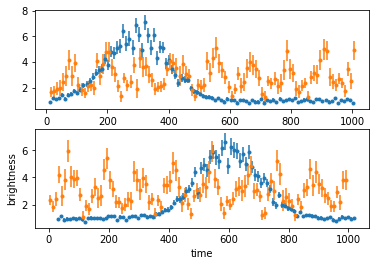

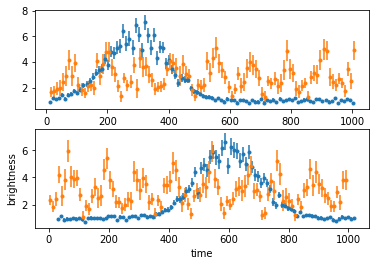

In [5]:
vis.plot_lcs([glc, slc])

# The overall strategy

We want to test the hypothesis that two lightcurves are noisy/sparse/irregular observations of the same object, under some permitted (afine) transformations.  Then we want to do clustering in the space of goodness-of-fit/consistency measure and the parameters of those transformations to identify classes.

regularize in time

In [6]:
# def regx(lca0, lcb0, lcc):
#     pass

## Permitted transformations

* shiftx
* stretchx
* shifty
* stretchy
* (cross-talk between bands)


also adjust error bars

should we first identify zero point in time to not have to worry as much about the arclength optimization? 
could we do that with fourier transform first?
start with large grid, then refine grid, dayish scales

# Reduce to summary statistics (consistency metric)

Contenders:

* periodogram -- identify periodicity and stochastic noise levels, still okay to initially divide transient from variable
* flux per time bins -- trends keeping bin size constant but changing bin ends, i.e. moving window
* abs/percent change in color and total flux/magnitude

find MAP/MLE of p(A = B | lc_A, lc_B)
marginalize over shift/stretch params

Regularization is going to be really hard!

connect the dots is taking an arc length

could use the gaussian error bars to get probability that new hypothesis point lies on original line?

Random ideas: gaussian process kernels based on training set, get probability that connect-the-dots is drawn from that distribution; but, we know training set will be biased/incomplete, so will have to be able to adapt kernel, use some kind of exporation of space of kernels (gradient descent, genetic algorithm, etc.)

Consider the arclength.  If the two lightcurves came from the same object, then their arclengths should be comparable to one another (if over the same range).  Merging the lightcurves should not significantly affect the total arclength.  We could also consider an area between curves

Let's try doing an optimization to find the transformation parameters minimizing the arclength ratio.

In [7]:
aff = affine.Aff(50., 1., 1., 1.5)
glc2 = affine.transform(glc, aff)

aff = summ.opt_arclen(glc, glc2, vb=False)
print (aff)

Aff(tx=0.0006215878286622565, ty=0.0007218442148513359, dx=0.9200502285811172, dy=0.5696623796660673)


In [12]:
aff2 = summ.opt_gp(glc, glc2, vb=False, options={'maxiter':1009})
print (aff2)

 /home/davyd/anaconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:43: RuntimeWarning:overflow encountered in square
 /home/davyd/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:167: RuntimeWarning:overflow encountered in true_divide
 /home/davyd/anaconda3/lib/python3.6/site-packages/GPy/kern/src/rbf.py:46: RuntimeWarning:invalid value encountered in multiply


Aff(tx=0.0013826033086273863, ty=0.0009240344295148155, dx=1.0109648213414075, dy=0.5590125912812656)


In [13]:
for x,y in zip(aff,aff2):
    print (x-y)

-0.0007610154799651298
-0.0002021902146634797
-0.09091459276029035
0.010649788384801684


Let's try just doing this with merging and shifting for now and test it when the lightcurves have the same class.

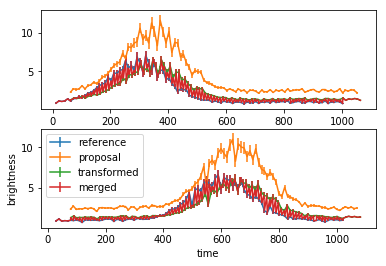

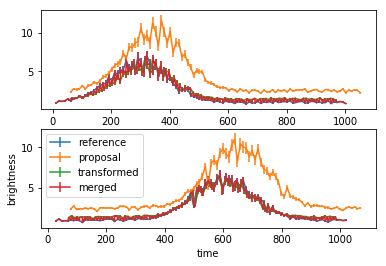

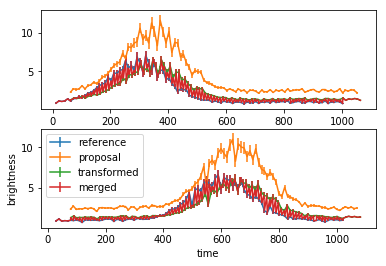

In [17]:
vis.plot_arclen_res(glc, glc2, aff)
vis.plot_arclen_res(glc, glc2, aff2)

In [18]:
glc3 = lightcurve.merge(glc, affine.transform(glc2, aff))

# GPy Attempt

In [19]:
def_cadence = np.vstack((np.arange(0., 1000., 10.),np.arange(0., 1000., 10.))).T
pred, like = summ.pred_gp(glc3, def_cadence)
print (pred.x.shape, like)

(100, 2) 7.816923832683528


### Note to self: Turn this into plotting code

In [21]:
m = GPy.models.gp_regression.GPRegression(np.array(glc3.x), np.array(glc3.y), normalizer=Tru)

print (glc3.yerr.shape)
newLC = lightcurve.LC(m.X, m.Y, glc3.yerr)
def_cadence = np.vstack((np.arange(0., 1000., 10.),np.arange(0., 1000., 10.))).T
quants = m.predict_quantiles(def_cadence)



(200, 2)


In [25]:
lowers0, lowers1 = zip(*quants[0])
uppers0, uppers1 = zip(*quants[1])

(-2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.7718076486993564, -2.771807648

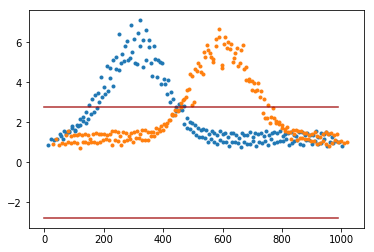

In [23]:
plt.clf()
plt.scatter(glc3.x[:,0],glc3.y[:,0],marker='.')
plt.scatter(glc3.x[:,1],glc3.y[:,1],marker='.')
plt.plot(def_cadence[:,0],lowers0, 'k-', alpha=.5)
plt.plot(def_cadence[:,0],uppers0, 'k-', alpha=.5)
plt.plot(def_cadence[:,1],lowers1, 'r-', alpha=.5)
plt.plot(def_cadence[:,1],uppers1, 'r-', alpha=.5)

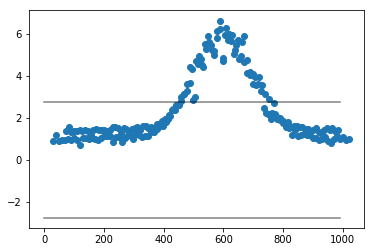

In [24]:
plt.clf()
plt.scatter(glc3.x[:,1],glc3.y[:,1])
plt.plot(def_cadence[:,1],lowers1, 'k-', alpha=.5)
plt.plot(def_cadence[:,1],uppers1, 'k-', alpha=.5)

In [ ]:
vis.plot_lcs(newLC)

# Currently broken after here due to multidim changes!!

### Gaussian processes as an alternative to the arclength

In [ ]:
from george import kernels
# help(kernels.ExpSquaredKernel)

In [ ]:
glc4 = lightcurve.LC(np.vstack(glc3.x).T,np.vstack(glc3.y).T,np.vstack(glc3.yerr).T)

In [ ]:
# this is definitely not the right kernel for the job!
def_cadence = np.vstack((np.arange(0., 1000., 10.)),)
kernel = np.var(glc4.y) * kernels.ExpSquaredKernel(10.)
lcf, fin_like = summ.fit_gp(kernel, glc4, def_cadence)

vis.plot_gp_res(glc4, lcf)

# Broken after this point!  Will turn the rest into scripts

# Do this many times!

Set up the simulation parameters

In [ ]:
num_obj = 10
cls_models = [make_gauss, make_sine]
cls_params = [{'scale': 10., 'loc': 100., 'amp': 50., 'const': 1.}, 
              {'period': 20., 'phase': 0., 'amp': 5., 'const': 5.}]
cls_wts = None # even split for now
num_cls = len(cls_models)
# will need a way to draw model params

def_cadence = np.arange(0., 200., 5.)
lcs = []
truth = np.random.choice(range(num_cls), num_obj, p=cls_wts)
ids, inds, cts = np.unique(truth, return_counts=True, return_inverse=True)
# print(ids, cts, inds)

Make some lightcurves and record which are of the same class.

In [ ]:
for i in range(num_obj):
    times = make_cadence(def_cadence, 0.5)
    model = cls_models[ids[inds[i]]](**cls_params[ids[inds[i]]])
    phot, err = apply_err(model(times), 0.1)
    lcs.append(LC(times, phot))
    
masks = np.zeros((num_cls, num_obj, num_obj))
for i in ids:
    which_ones = np.where(truth == i)[0]
#     print(which_ones)
    pairs = np.array(list(itertools.permutations(which_ones, 2))).T
#     print(pairs)
    masks[i, pairs[0], pairs[1]] += 1
    
# print(masks)

Let's loop over the optimization, comparing pairwise.  We won't worry about skipping duplication yet because we can use it as a null test of whether this is working.

In [ ]:
def mini_pipeline(all_lcs):
    how_many = len(all_lcs)
    indices = range(how_many)
    dump_difs = np.empty((how_many, how_many))
    dump_params = []
    
    for i in indices:
        one_set = []
        for j in indices:
            ans, fin_len = find_max_prob(all_lcs[i], all_lcs[j])
#             print(i, j, ans, fin_len)
            one_set.append(np.asarray(ans.x))
            dump_difs[i][j] = fin_len
        dump_params.append(one_set)
    dump_params = np.array(dump_params)
            
    return(dump_params, dump_difs)

In [ ]:
all_params, all_difs = mini_pipeline(lcs)

In [ ]:
for i in range(num_obj):
    for j in range(num_obj):
        print((i, j, all_difs[i][j]))
        plot_reconstruct(lcs[i], lcs[j], all_params[i][j], truea=str(truth[i]), trueb=str(truth[j]))

In [ ]:
print(np.shape(truth))

In [ ]:
for i in range(num_obj):
    for j in range(num_obj):
        print((i, j, truth[i], truth[j]))
        try_to_fit(merge(lcs[i], transform(lcs[j], all_params[i][j][0], all_params[i][j][1], all_params[i][j][2], all_params[i][j][3])))

## Visualizations below

In [ ]:
# check for symmetry -- really thought these would be symmetric. . .
plt.matshow(np.sum(masks, axis=0))
layered = np.swapaxes(all_params, 0, -1)

deltafunc = lambda x: np.abs(x)
stretchfunc = lambda x: np.min(np.array([x, 1./x]).T, axis=-1)
funcs = [deltafunc, deltafunc, stretchfunc, stretchfunc]

for i in range(4):
    plt.matshow(funcs[i](layered[i]))
    plt.plot([0, num_obj-1], [0, num_obj-1], color='k')

Visually, this doesn't seem to be working well

# Cluster in the space of summary statistics

kdtree (and more)

We want to see if the stretch/shear parameters for a class are clustered.

In [ ]:
global_mask = np.zeros((num_obj, num_obj))
# for i in range(4):
#     global_mask = np.logical_or(global_mask, masks[i])
for i in range(num_cls):
    global_mask = np.logical_or(global_mask, masks[i])
    plt.hist((all_difs * masks[i]).flatten(), alpha=0.25, label=str(i))
plt.hist(all_difs[~global_mask[i]].flatten(), alpha=0.25, label='no match')
plt.legend()

This sort of makes sense because we expect pairs of (s, 1/s) for stretch s and (t, -t) for translation t.

In [ ]:
corner.corner(all_params.reshape(100, 4))

Ouch, they really aren't symmetric nor interpretable.  But this is a very small sample size. . . so let's do it a little better.

# Let's try another approach :-}

In [ ]:
def listerize(data, masks):
    datashape = np.shape(data)
    global_mask = np.ma.make_mask_none(np.shape(masks)[1:])
    layers = []
    for i in range(len(masks)):# per class
        one_mask = np.ma.make_mask(masks[i])
        layer = np.ma.array(data, mask=np.ma.logical_not(one_mask)[np.newaxis])#data * masks[i][np.newaxis]
        global_mask = np.ma.mask_or(global_mask, one_mask)
        layers.append(layer.compressed())
        
    global_mask = np.ma.make_mask(global_mask)
    others = np.ma.array(data, mask=global_mask[np.newaxis]).compressed()#data * ~global_mask[np.newaxis]
    return(layers, others)

In [ ]:
per_class, mismatch = listerize(all_difs, masks)

In [ ]:
def density_estimation(m1, m2):
    X, Y = np.mgrid[min(m1):max(m1):100j, min(m2):max(m2):100j]                                                     
    positions = np.vstack([X.ravel(), Y.ravel()])                                                       
    values = np.vstack([m1, m2])                                                                        
    kernel = sps.gaussian_kde(values)                                                             
    Z = np.reshape(kernel(positions).T, X.shape)
    return X, Y, Z

def mycorner(data, keys, colors, maps, lims=None, pre_densities=None, filename='plot.pdf'):
    ncol = len(keys)
    fig = plt.figure(figsize=(ncol*5, ncol*5))
    ax = [[fig.add_subplot(ncol, ncol, ncol * i + j + 1) for j in range(i+1)] for i in range(ncol)]
#     print(len(data), len(colors))
    for k in range(len(data)):
        datum = data[k]
        npoints = len(datum)
        for i in range(ncol):
            for j in range(i+1):
                if i == j:
#                     print(datum[keys[i]])
                    ax[i][j].hist(datum[i].data, histtype='step', linewidth=2, alpha=0.5, color=colors[k])
                    ax[i][j].set_xlabel(keys[i])
                else:
#                     if (npoints >= 1e4 or npoints <= 100):
                    ax[i][j].scatter(datum[i].data, datum[j].data, color=colors[k], alpha=0.5)
#                     else:
#                         if pre_densities is None:
#                             x, y, z = density_estimation(datum[keys[i]], datum[keys[j]])
#                         else:
#                             (x, y, z) = pre_densities[i][j]
#                         ax[i][j].contour(x, y, z, cmap=plt.get_cmap(maps[k]) , alpha=0.5)
                    ax[i][j].set_xlabel(keys[i])
                    ax[i][j].set_ylabel(keys[j])
#                     if lims is not None:
#                         ax[i][j].set_xlim(lims)
#                         ax[i][j].set_ylim(lims)
#     fig.savefig(filename, dpi=100)
    return#(fig)
# replace with 2d histogram for speed

In [ ]:
print per_class[0].shape, per_class[1].shape
print len(mismatch)

In [ ]:
# mycorner([per_class[0], per_class[1], mismatch], ['deltax', 'deltay', 'stretchx', 'stretchy'], ['r', 'g', 'b'], ['Reds', 'Greens', 'Blues'])

Nope, this still doesn't look like anything. . .

In [ ]:
for i in range(num_obj):
    for j in range(num_obj):
        plot_reconstruct(lcs[i], lcs[j], all_params[i][j], truea=str(truth[i]), trueb=str(truth[j]))

# Other ideas

pairwise combinations/comparisons?

space partitioning -- try to estimate

$$\int_{\theta \in D} p(x|\theta) d\theta$$

then we can iteratively refine. maybe have coarse upper/lower bounds by sampling discrete $\theta$ and multiplying by the volume of $D$, idk.

if we have independent observations $y_i$ and times $x_i$, maybe we want the product probability that some underlying function $f$ generated those points

$$\prod_i p(y_i | \theta)$$

if the error distributions are just gaussians with standard deviation $\sigma$ then the logprob is

$$\log \left(\prod_i \frac{1}{\sqrt{2\pi}} e^{-\frac{1}{2}\left(\frac{f(x_i)-y_i}{\sigma}\right)^2} \right)$$

which is for some constant $|C|$,

$$-|C| \sum_i \left(f(x_i) - y_i\right)^2$$

if $f$ is differentiable like the sine function, i think we can get a closed-form solution for finding the min (closest parameters). we probably want something more bayesian, but i imagine the probabilities fall off kinda fast from the min point, so having it as a reference might be nice.

In [ ]:
from scipy.stats import norm as scipy_norm

x = np.linspace(scipy_norm.ppf(0.01),
                scipy_norm.ppf(0.99), 100)
plt.plot(x, scipy_norm.pdf(x, 1, 2),
        'r-', lw=5, alpha=0.6, label='norm pdf')

In [ ]:
x = np.linspace(scipy_norm.ppf(0.01),
                scipy_norm.ppf(0.99), 100)
plt.plot(x, scipy_norm.pdf((x - 1) / 2),
        'r-', lw=5, alpha=0.6, label='norm pdf')

In [ ]:
# def logsum_p_obs(expected, observed, noise_scale):
#     diffs = 